# Convolutions for Images

In [9]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

## The Cross-Correlation Operation

Strictly speaking, convolutional layers are better described as cross-correlations. An input tensor and a kernel tensor (the weights) are combined to produce an output tensor through a cross-correlation operation. 

For now, look at how this works for 2D data with no channels. Shape of the input tensor is (3, 3) and shape of kernel is (2, 2). Begin with kernel in top left and slide across the tensor, left to right and top to bottom. When the convolution window slides to a certain position, the input subtensor and the kernel filter are multiplied element-wise to produce a scalar output, which is one element in the output tensor. 

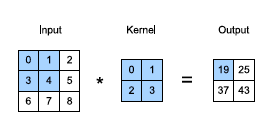

So, in the example above, we would have 

$$ 0 \times 0 + 1 \times 1 + 3 \times 2 + 4 \times 3 = 19 $$
$$ 1 \times 0 + 2 \times 1 + 4 \times 2 + 5 \times 3 = 25 $$

And so on..

When sliding the kernal across the image, we can only properly compute the output values for cases where the kernel fits wholly within the image, so the output is slightly smaller than the input. Later we will pad the image with zeros around the outside (by adding half the kernel height to the top/bottom and half the width to either side I guess, plus 1). 

Lets implement this simple version from scratch

In [4]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)) # down column along row
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()
    return Y

In [6]:
# Lets validate what we worked out manually above

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## Convolutional Layers

A convolutional layer includes a bias, typically initialise kernels randomly as we would with the previously explored fully-connected layers. 


In [7]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.save_hyperparameters()

        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

## Object Edge Detection in Images

Make a fake image with easy to find edges to demonstrate, 6x8 pixels, the middle four columns are black, with the rest white. 

In [10]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

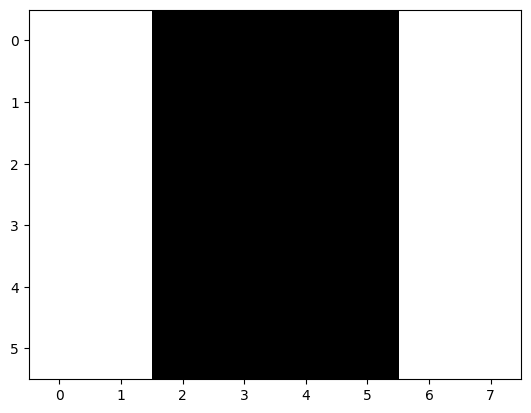

In [19]:
# plt.imshow(X, cmap='Greys') Ha! Confusingly, this inverts the colours.
plt.imshow(X, cmap='gray')

Define a (1 x 2) kernel [1, -1], so that it returns 0 when the pixels in the inputs are the same and +/-1 when they differ.

In [20]:
K = torch.tensor([[1., -1.]])

In [21]:
Y = corr2d(X, K)

In [22]:
print(Y)

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


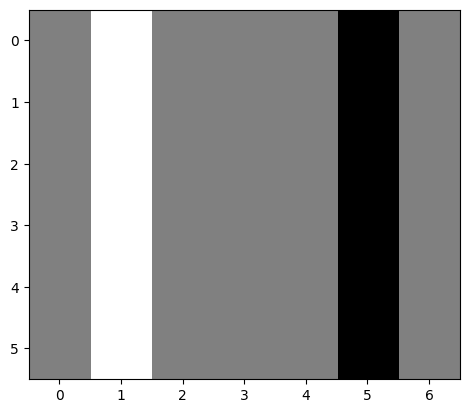

In [24]:
plt.imshow(Y, cmap='gray')

As we might expect form the shape of the kernel, it can only detect horizontal edges, so when we try this with the transposed image, it vanishes 

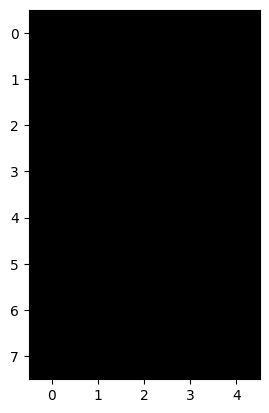

In [27]:
plt.imshow(corr2d(X.t(), K), cmap='gray')

## Learning a Kernel

Of course, we don't want to be manually specifying the filters/kernels! We want to learn them. Here we will hgenerate one by looking ast the input/output pairs

In [30]:
# Use library function here, ignore bias
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# nn.LazyConv2d expects 4d input, (example, channel, height, width)
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X) # Make a forwards predictions
    loss = (Y_hat - Y) ** 2 # compute the loss
    conv2d.zero_grad() # zero gradients
    loss.sum().backward() # compute the gradients

    conv2d.weight.data[:] -= lr * conv2d.weight.grad # update the weights by subtracting gradients * lr

    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {loss.sum():.3f}')

epoch 2, loss 13.217
epoch 4, loss 4.509
epoch 6, loss 1.695
epoch 8, loss 0.669
epoch 10, loss 0.270


In [31]:
conv2d.weight.data.reshape((1, 2))  # Pretty close to [[1, -1]]!

tensor([[ 1.0433, -0.9366]])

## Cross-correlation and convolution

Technically, the operation we have just performed is a cross-correlation, not a convolution, as the fwe woudl need to flip the two-dimensional kernel tensor both horizontally and vertically for this to be a convolution. Of course. then, the learned kernel would be the same, making this whole thing an issue of semantics. 

## Feature Map and Receptive Field

The convolutional layer output is sometimes called a _feature map_, since it can be regarded as the learned features required as input to the concatenated layer. The _receptive field_ refers to all the elements of all the tensors which may affect the value of an output tensor x during calculation.

## Summary

The core copmutation required for a convolutional layer is a cross-correlation operation, where a kernel tensor is slid across the input image to compute the output at each index. This saves on memory and allows us to focus on computational speed, which is a major reason for why modern computer vision has been so successful. The convolutional kernels themselves can be used for many purposes, edge detection, blurring, sharpening, etc. We don't have to design kernels, we just learn them. 